In [1]:
import numpy as np
import scipy.fftpack as sfft
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import h5py
import pickle
import constants as cst
from honeycomb import GetRecLatt
from LatticeInteraction import LattInter
import sys
import os
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib notebook

import Reading_Scripts as Reading
import Plotting_Scripts as Plotting
import Fourier_Transforms as Fourier
import Coulomb_Potentials as Potentials

np.set_printoptions(threshold=np.inf)

#%matplotlib widget

/home/juanmosquera/anaconda3/lib/python3.11/site-packages/hankel/tools.py:14: RuntimeWarning: overflow encountered in sinh
  return t * np.tanh(np.pi * np.sinh(t) / 2)
/home/juanmosquera/anaconda3/lib/python3.11/site-packages/hankel/tools.py:14: RuntimeWarning: overflow encountered in multiply
  return t * np.tanh(np.pi * np.sinh(t) / 2)


In [2]:
def PlotVintrold(irvec,Vint_r,orbitales,lat,i_orb,j_orb,color_l,label_l,stilo):
    xs = irvec[:,0] + (orbitales[i_orb,0] - orbitales[j_orb,0])
    ys = irvec[:,1] + (orbitales[i_orb,1] - orbitales[j_orb,1])
    zs = irvec[:,2] + (orbitales[i_orb,2] - orbitales[j_orb,2])

    a1, a2, a3 = lat[0,:], lat[1,:], lat[2,:]

    rvecs = xs[:,None] * a1[None,:] + ys[:,None] * a2[None,:]+ zs[:,None] * a3[None,:]
    ds = np.sqrt(rvecs[:,0]**2 + rvecs[:,1]**2 + rvecs[:,2]**2)


    Ix = np.argsort(ds)

    #fig, ax = plt.subplots()

    ax.plot(ds[Ix], cst.Ry * Vint_r[i_orb,j_orb,Ix],stilo,color=color_l,label=label_l,linewidth=2)
    ax.legend(fontsize=13)
    ax.set_xlabel(r"Distance $(\AA)$",fontsize=13)
    #ax.set_ylabel(r"$V_{bare}\left(\left| r \right|\right)\  (eV)$",fontsize=13)
    ax.set_ylabel(r"Electron-Electron Interactions  $(eV)$",fontsize=13)
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)

def ScreenVintq(nk1,nk2,nk3,Vint_q,lat,alpha,eq0,n_bar):
    nk = nk1 * nk2 * nk3
    b1, b2, b3 = GetRecLatt(lat[0,:],lat[1,:],lat[2,:])
    x1 = np.linspace(-0.5,0.5, nk1+1)
    x2 = np.linspace(-0.5,0.5, nk2+1)
    x3 = np.linspace(-0.5,0.5, nk3+1)
    X, Y, Z = np.meshgrid(x1[0:nk1], x2[0:nk2],x3[0:nk3])
    #X, Z, Y = np.meshgrid(x1[0:nk1],x3[0:nk3], x2[0:nk2])
    #Y, X, Z = np.meshgrid(x2[0:nk2], x1[0:nk1],x3[0:nk3])
    #Y, Z, X = np.meshgrid( x2[0:nk2],x3[0:nk3], x1[0:nk1])
    #Z, X, Y = np.meshgrid(x3[0:nk3], x1[0:nk1],x2[0:nk2])
    #Z, Y, X = np.meshgrid(x3[0:nk3], x2[0:nk2],x1[0:nk1])
    qx = np.reshape(X, [nk])
    qy = np.reshape(Y, [nk])
    qz = np.reshape(Z, [nk])
    
    #print(qx)
    #print(qy)
    
    parcialx=np.array([1,0,0])
    parcialy=np.array([0,1,0])
    parcialz=np.array([0,0,1])


    qvecs = qx[:,None] * b1[None,:] + qy[:,None] * b2[None,:] + qz[:,None] * b3[None,:]
    #qvecs = qx[:,None]*parcialx[None,:] + qy[:,None]*parcialy[None,:] + qz[:,None]*parcialz[None,:] 
    qr = np.sqrt(qvecs[:,0]**2 + qvecs[:,1]**2 + qvecs[:,2]**2)
    
    #for i in range(len(qr)):
    #    print(qr[i],Vint_q[0,0,i])

    Ixq = np.argsort(qr)
    plt.plot(qr/np.max(qr),".")
    plt.plot(Vint_q[0,0,:]/np.max(Vint_q[0,0,:]),"-")
    
    eps_di = ModelDielectric(qr[Ixq],alpha,eq0,n_bar)
    plt.plot(eps_di/np.max(eps_di),"--")
    #eps_di = ModelDielectric(qr,alpha,eq0,n_bar)

    #print(np.amin(eps_di), np.amax(eps_di))
    
    IxV = np.flip(np.argsort(Vint_q[0,0,:]))
    #plt.plot(qr,Vint_q[0,0,:],"--")
    #plt.plot(qr/np.max(qr),'-')
    #plt.plot(Vint_q[0,0,:]/np.max(Vint_q[0,0,:]),'-')
    #plt.plot(qr,Vint_q[0,0,:])
    
    #plt.plot(qr,Vint_q[0,0,Ix],'.')
    
    W_q = Vint_q / eps_di[None,None,:]
    

    return W_q


def ModelDielectric(q,eq0,n_bar,alpha):
    eps1 = 1 + 1 / (  1/(eq0 - 1) +alpha*(q/ (2*(3*n_bar/np.pi)**(1/6))   )**2 + q**4/(4*np.sqrt(4*np.pi*n_bar))  )

    return eps1

In [3]:
system="BlackP"


path     = "./../../DATA/data_Screening/"
out_path = "./../../OUT/Screening_Interaction_out/"
name_lat = path+system+'/Lattice'
orbitales,parameters = Reading.ReadLattice(name_lat+'.h5')

a = 3.31067978852923 / cst.aB
b = 4.58545824667620 / cst.aB
c = 10.9888937548268 / cst.aB


lat = np.zeros([3,3])
lat[0,:] =  np.array([a,  0.0, 0.0])
lat[1,:] =  np.array([0.0,  b, 0.0])
lat[2,:] =  np.array([0.0, 0.0,  c])

a1, a2, a3 = lat[0,:], lat[1,:], lat[2,:]


#irvec_w_e_F, whubb_F, wlatt_e_F = ReadVint_realspace("out/"+system+"_felipe_scrW_real.h5")
#irvec_w_e_M, whubb_M, wlatt_e_M = ReadVint_realspace("out/"+system+"_michael_scrW_real.h5")
irvec_w_e_Z, whubb_Z, wlatt_e_Z = Reading.ReadVint_realspace(out_path+system+"_Zero_12x12x8_scrW_real.h5")

irvec_w_e_H_12_8, whubb_H_12_8, wlatt_e_H_12_8 = Reading.ReadVint_realspace(out_path+system+"_Hubb_12x12x8_scrW_real.h5")
irvec_w_e_H_16_8, whubb_H_16_8, wlatt_e_H_16_8 = Reading.ReadVint_realspace(out_path+system+"_Hubb_16x16x8_scrW_real.h5")
irvec_w_e_H_16_12, whubb_H_16_12, wlatt_e_H_16_12 = Reading.ReadVint_realspace(out_path+system+"_Hubb_16x16x12_scrW_real.h5")
irvec_w_e_H_24_8, whubb_H_24_8, wlatt_e_H_24_8 = Reading.ReadVint_realspace(out_path+system+"_Hubb_24x24x8_scrW_real.h5")
irvec_w_e_H_24_12, whubb_H_24_12, wlatt_e_H_24_12 = Reading.ReadVint_realspace(out_path+system+"_Hubb_24x24x12_scrW_real.h5")
irvec_w_e_H_32_8, whubb_H_32_8, wlatt_e_H_32_8 = Reading.ReadVint_realspace(out_path+system+"_Hubb_32x32x8_scrW_real.h5")
#irvec_w_e_H_24, whubb_H_24, wlatt_e_H_24 = ReadVint_realspace("out/"+system+"_hubb_32x32x16_scrW_real.h5")

#irvec_w_e_F_16, whubb_F_16, wlatt_e_F_16 = Reading.ReadVint_realspace("out/"+system+"_Felipe_16x16x12_scrW_real.h5")
#irvec_w_e_F_24, whubb_F_24, wlatt_e_F_24 = Reading.ReadVint_realspace("out/"+system+"_Felipe_24x24x12_scrW_real.h5")
irvec_w_e_F_12_8, whubb_F_12_8, wlatt_e_F_12_8 = Reading.ReadVint_realspace(out_path+system+"_Felipe_12x12x8_scrW_real.h5")
irvec_w_e_F_16_8, whubb_F_16_8, wlatt_e_F_16_8 = Reading.ReadVint_realspace(out_path+system+"_Felipe_16x16x8_scrW_real.h5")
irvec_w_e_F_16_12, whubb_F_16_12, wlatt_e_F_16_12 = Reading.ReadVint_realspace(out_path+system+"_Felipe_16x16x12_scrW_real.h5")
irvec_w_e_F_24_8, whubb_F_24_8, wlatt_e_F_24_8 = Reading.ReadVint_realspace(out_path+system+"_Felipe_24x24x8_scrW_real.h5")
irvec_w_e_F_24_12, whubb_F_24_12, wlatt_e_F_24_12 = Reading.ReadVint_realspace(out_path+system+"_Felipe_24x24x12_scrW_real.h5")
irvec_w_e_F_32_8, whubb_F_32_8, wlatt_e_F_32_8 = Reading.ReadVint_realspace(out_path+system+"_Felipe_32x32x8_scrW_real.h5")
irvec_w_e_F_32_12, whubb_F_32_12, wlatt_e_F_32_12 = Reading.ReadVint_realspace(out_path+system+"_Felipe_32x32x12_scrW_real.h5")



irvec_v_trial, whubb_v_trial, wlatt_v_trial = Reading.ReadVint_realspace(path+"BlackP/Vbare_crpa_Felipe.h5")
irvec_v_extendido, whubb_v_extendido, wlatt_v_extendido = Reading.ReadVint_realspace(path+"BlackP/Vbare_crpa_extendido_plus+.h5")
#irvec_v_trial, whubb_v_trial, wlatt_v_trial = ReadVint_realspace("data/BlackP/Vbare_crpa_better.h5")

#ds, W_numerics = PlotVintr(irvec_w_e, wlatt_e, lat,1)


NameError: name 'PlotVintr' is not defined

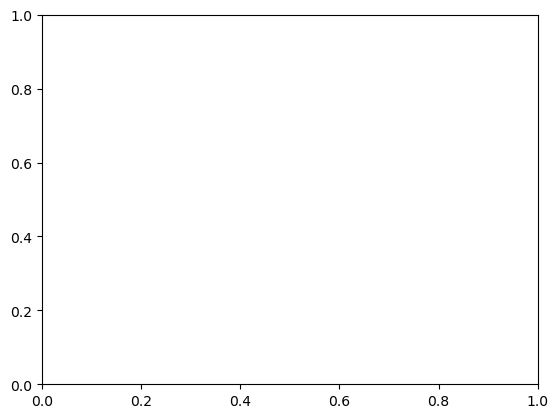

In [4]:

i_orb=0
j_orb=0



fig, ax = plt.subplots()

#PlotVintr(irvec_v, wlatt_v,whubb_v, lat,"V",i,j,"orange")
#PlotVintr(irvec_v_trial, wlatt_v_trial,whubb_v_trial, lat,"V_trial",i,j,"black")

#PlotVintr(irvec_w_e_F, wlatt_e_F,whubb_F, lat,"Felipe",i,j,"purple")
#PlotVintr(irvec_w_e_M, wlatt_e_M,whubb_M, lat,"Michael",i,j,"blue")
#Plotting.PlotVintr(irvec_w_e_Z,    wlatt_e_Z,    whubb_Z,    orbitales, lat,"zero",i_orb,j_orb,"black")


#Plotting.PlotVintr(irvec_w_e_H_12, wlatt_e_H_12, whubb_H_12, orbitales, lat,"Hubb 12x12x8",i_orb,j_orb,"red")
#PlotVintr(irvec_w_e_F_12_8, wlatt_e_F_12_8, whubb_F_12_8, orbitales, lat,"$W^{fitt}_{0,0}\ 12x12x8$",i_orb,j_orb,"blue")
#PlotVintr(irvec_w_e_F_16_8, wlatt_e_F_16_8, whubb_F_16_8, orbitales, lat,"$W^{fitt}_{0,0}\ 16x16x8$",i_orb,j_orb,"blue")
#PlotVintr(irvec_w_e_F_16_12, wlatt_e_F_16_12, whubb_F_16_12, orbitales, lat,"$W^{fitt}_{0,0}\ 16x16x12$",i_orb,j_orb,"black")
#PlotVintr(irvec_w_e_F_24_8, wlatt_e_F_24_8, whubb_F_24_8, orbitales, lat,"$W^{fitt}_{0,0}\ 24x24x8$",i_orb,j_orb,"blue")
#PlotVintr(irvec_w_e_F_24_12, wlatt_e_F_24_12, whubb_F_24_12, orbitales, lat,"$W^{fitt}_{0,0}\ 24x24x12$",i_orb,j_orb,"red")
#PlotVintr(irvec_w_e_F_32_8, wlatt_e_F_32_8, whubb_F_32_8, orbitales, lat,"$W^{fitt}_{1,29}\ 32x32x8$",i_orb,j_orb,"purple")
PlotVintr(irvec_w_e_F_32_12, wlatt_e_F_32_12, whubb_F_32_12, orbitales, lat,"$W^{fitt}_{0,0}\ 32x32x12$",i_orb,j_orb,"blue")
#Plotting.PlotVintr(irvec_w_e_H_24, wlatt_e_H_24, whubb_H_24, orbitales, lat,"Hubb 24x24x8",i_orb,j_orb,"red")
#Plotting.PlotVintr(irvec_w_e_H_32, wlatt_e_H_32, whubb_H_32, orbitales, lat,"Hubb 32x32x8",i_orb,j_orb,"red")

#PlotVintr(irvec_w_e_F_16, wlatt_e_F_16, whubb_F_16, orbitales, lat,"Felipe 16x16x8",i_orb,j_orb,"blue")
#Plotting.PlotVintr(irvec_w_e_F_24, wlatt_e_F_24, whubb_F_24, orbitales, lat,"Felipe 24x24x8",i_orb,j_orb,"blue")
#PlotVintr(irvec_w_e_F_32, wlatt_e_F_32, whubb_F_32, orbitales, lat,"Felipe 32x32x8",i_orb,j_orb,"purple")

#Plotting.PlotVintr(irvec_w_e_F_16, wlatt_e_F_16, whubb_F_16, orbitales, lat,"Felipe 16x16x8",i,j,"red")
#Plotting.PlotVintr(irvec_w_e_F_24, wlatt_e_F_24, whubb_F_24, orbitales, lat,"Felipe 24x24x12",i,j,"red")
PlotVintr(irvec_v_trial, wlatt_v_trial,whubb_v_trial, orbitales, lat,"$V^{fitt}_{0,0}$",i_orb,j_orb,"red")
#PlotVintr(irvec_v_trial, wlatt_v_trial ,whubb_v_trial , orbitales, lat,"$V^{fitt}_{1,29}$",i_orb,j_orb,"blue")
#PlotVintr(irvec_v_trial, wlatt_v_trial,whubb_v_trial, orbitales, lat,"$V^{fitt}_{0,1}$",j_orb,i_orb,"blue")
##PlotVintr(irvec_w_e_H_16, wlatt_e_H_16,whubb_H_16, lat,"Hubb",i_orb,j_orb,"black")
#PlotVintr(irvec_w_e_H_24, wlatt_e_H_24,whubb_H_24, lat,"Hubb",i,j,"green")
#ax.set_ylim(0,4)

#plt.legend()
#plt.ylim(-0.2,0.2)
plt.ylim(0,1)
#PlotVintr(irvec, W_r, lat,1,2)
#plt.savefig("comparison_0_0_zoom_second_"+system+".png", bbox_inches="tight", transparent=False)
plt.show()


In [5]:
volumen=a*b*c
number_of_electrons = 48
n_bar=number_of_electrons/volumen

alpha = 1.563
desviacion = 8.0

alpha_array = np.linspace(0,alpha+desviacion,30) 

eq0=6.36

Wint_rF = Reading.Joining(irvec_w_e_F_32_12, wlatt_e_F_32_12, whubb_F_32_12 , orbitales, lat)
Vint_rT = Reading.Joining(irvec_v_trial, wlatt_v_trial ,whubb_v_trial, orbitales, lat)

print("Read")


Read


[0.         0.32975862 0.65951724 0.98927586 1.31903448 1.6487931
 1.97855172 2.30831034 2.63806897 2.96782759 3.29758621 3.62734483
 3.95710345 4.28686207 4.61662069 4.94637931 5.27613793 5.60589655
 5.93565517 6.26541379 6.59517241 6.92493103 7.25468966 7.58444828
 7.9142069  8.24396552 8.57372414 8.90348276 9.23324138 9.563     ]


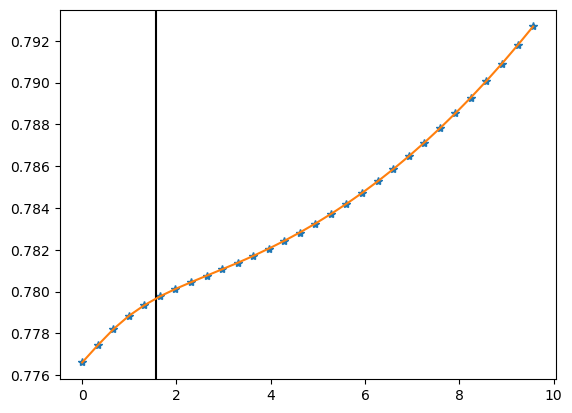

In [13]:
big_error = Potentials.Minimization_Alpha(irvec_v_trial,Vint_rT,irvec_w_e_F_32_12,Wint_rF,orbitales,lat,eq0,n_bar,alpha_array)

plt.plot(alpha_array[:],big_error[:],"*")

alpha_interp=np.linspace(alpha_array[0],alpha_array[-1],200)
error_interp=np.interp(alpha_interp,alpha_array, big_error)
plt.axvline(x=alpha,color="black")
plt.plot(alpha_interp,error_interp)
print(alpha_array[:])

In [5]:
volumen=a*b*c
number_of_electrons = 48
n_bar=number_of_electrons/volumen

alpha = 1.563
eq0=6.36

Wint_rF = Reading.Joining(irvec_w_e_F_32_12, wlatt_e_F_32_12, whubb_F_32_12 , orbitales, lat)
Vint_rT = Reading.Joining(irvec_v_trial, wlatt_v_trial ,whubb_v_trial, orbitales, lat)

print("Read")

Read


In [ ]:
W_epsilon = Potentials.Screening_Long_Interaction(irvec_v_trial,Vint_rT,irvec_w_e_F_32_12,Wint_rF,orbitales,lat,eq0,n_bar,alpha)
#W_epsilon_short = Potentials.Screening_Short_Interaction(irvec_w_e_F_32_12,Wint_rF,orbitales,lat)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


[ 22.84132808 440.66651115 350.89997539]


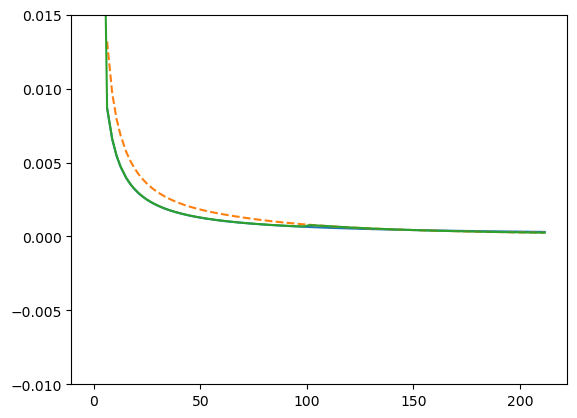

In [75]:
#plt.plot(dsF[IxF][1:],Wint_rF[i_orb,j_orb,IxF][1:],'o')
plt.plot(dsF[IxF][1:],W_epsilon_short[i_orb,j_orb,IxF][1:],'-')
plt.plot(dsF[IxF][1:],W_epsilon[i_orb,j_orb,IxF][1:],"--")


W_nuevo = rotation(2,dsF,IxF,100)*W_epsilon_short[i_orb,j_orb,:] + rotation(1,dsF,IxF,100)*W_epsilon[i_orb,j_orb,:]

plt.plot(dsF[IxF],W_nuevo[IxF] )

plt.ylim(-0.01,0.015)




NameError: name 'W_epsilon_short' is not defined

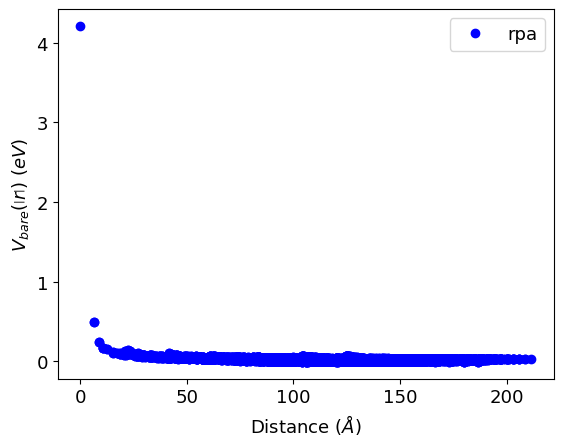

In [7]:
fig, ax = plt.subplots()


PlotVintrold(irvec_w_e_F_32_12,Wint_rF,orbitales,lat,0,0,"blue","rpa","o")
PlotVintrold(irvec_w_e_F_32_12,W_epsilon_short,orbitales,lat,0,0,"green","short",".")
PlotVintrold(irvec_w_e_F_32_12,W_epsilon,orbitales,lat,0,0,"black","long","--")

plt.ylim(-0.01,.1*27.2*0.5)

In [120]:
W_int_long  = Reading.ConstructInteraction(orbitales,irvec_w_e_F_32_12,W_epsilon)
W_int_short = Reading.ConstructInteraction(orbitales,irvec_w_e_F_32_12,W_epsilon_short)



fnameL = path+system+"/W_int_long.h5"
fnameS = path+system+"/W_int_short.h5"
W_int_long.SaveToHDF5(fnameL)
W_int_short.SaveToHDF5(fnameS)

In [8]:
irvec_v_L, whubb_L, wlatt_L = Reading.ReadVint_realspace(path+"BlackP/W_int_long.h5")
irvec_v_S, whubb_S, wlatt_S = Reading.ReadVint_realspace(path+"BlackP/W_int_short.h5")

Wread_L = Reading.Joining(irvec_v_L, wlatt_L, whubb_L , orbitales, lat)
Wread_S = Reading.Joining(irvec_v_S, wlatt_S, whubb_S, orbitales, lat)


In [20]:
W_epsilon_complete = np.zeros_like(Wint_rF)

for i_orb in range(0,32):
    for j_orb in range(0,32):

        xsF = irvec_w_e_F_32_12[:,0] + (orbitales[i_orb,0] - orbitales[j_orb,0])
        ysF = irvec_w_e_F_32_12[:,1] + (orbitales[i_orb,1] - orbitales[j_orb,1])
        zsF = irvec_w_e_F_32_12[:,2] + (orbitales[i_orb,2] - orbitales[j_orb,2])

        rvecsF = xsF[:,None] * a1[None,:] + ysF[:,None] * a2[None,:]+ zsF[:,None] * a3[None,:]

        dsF = np.sqrt(rvecsF[:,0]**2 + rvecsF[:,1]**2 + rvecsF[:,2]**2)

        IxF = np.argsort(dsF)

        if i_orb == j_orb:
        
            distancia = 75

            W_epsilon_complete[i_orb,j_orb,:] = Potentials.rotation(2,dsF,IxF,distancia)*Wread_S[i_orb,j_orb,:] + Potentials.rotation(1,dsF,IxF,distancia)*Wread_L[i_orb,j_orb,:]

        if i_orb != j_orb:
        
            distancia = 125

            W_epsilon_complete[i_orb,j_orb,:] = Potentials.rotation(2,dsF,IxF,distancia)*Wread_S[i_orb,j_orb,:] + Potentials.rotation(1,dsF,IxF,distancia)*Wread_L[i_orb,j_orb,:]

        
        if i_orb == j_orb:
            W_epsilon_complete[i_orb,j_orb,IxF[0]] = Wread_S[i_orb,j_orb,IxF[0]]
            
W_int_tout = Reading.ConstructInteraction(orbitales,irvec_w_e_F_32_12,W_epsilon_complete)

fnameT = "data/"+system+"/W_int_tout.h5"
W_int_tout.SaveToHDF5(fnameT)

In [12]:
irvec_v_L, whubb_L, wlatt_L = Reading.ReadVint_realspace(path+"BlackP/W_int_long.h5")
irvec_v_S, whubb_S, wlatt_S = Reading.ReadVint_realspace(path+"BlackP/W_int_short.h5")
irvec_v_T, whubb_T, wlatt_T = Reading.ReadVint_realspace(path+"BlackP/W_int_tout.h5")
#irvec_v_trial, whubb_v_trial, wlatt_v_trial = Reading.ReadVint_realspace(path+"BlackP/Vbare_crpa_Felipe.h5")
irvec_v_trial, whubb_v_trial, wlatt_v_trial = Reading.ReadVint_realspace(path+"BlackP/Vbare_crpa_extendido_plus+.h5")
Wread_L = Reading.Joining(irvec_v_L, wlatt_L, whubb_L , orbitales, lat)
Wread_S = Reading.Joining(irvec_v_S, wlatt_S, whubb_S, orbitales, lat)
Wread_T = Reading.Joining(irvec_v_T, wlatt_T, whubb_T, orbitales, lat)
Wint_rF = Reading.Joining(irvec_w_e_F_32_12, wlatt_e_F_32_12, whubb_F_32_12 , orbitales, lat)
V_bare  = Reading.Joining(irvec_v_trial, wlatt_v_trial, whubb_v_trial, orbitales, lat)

(-0.01, 0.1)

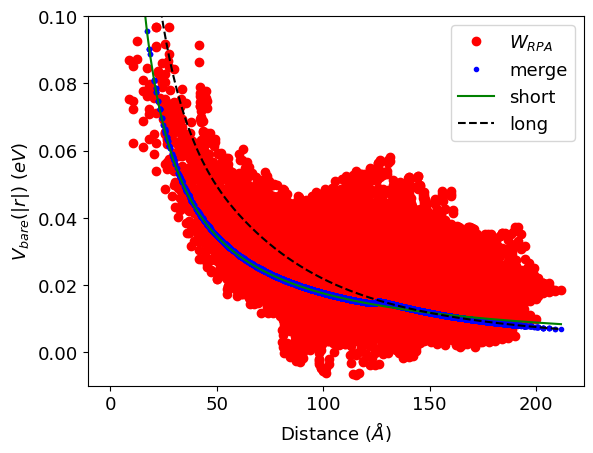

In [6]:
fig, ax = plt.subplots()


PlotVintrold(irvec_w_e_F_32_12,Wint_rF,orbitales,lat,1,0,"red",r"$W_{RPA}$","o")
PlotVintrold(irvec_v_L,Wread_T,orbitales,lat,1,0,"blue","merge",".")
PlotVintrold(irvec_v_S,Wread_S,orbitales,lat,1,0,"green","short","-")
PlotVintrold(irvec_v_T,Wread_L,orbitales,lat,1,0,"black","long","--")

plt.ylim(-0.01,0.1)

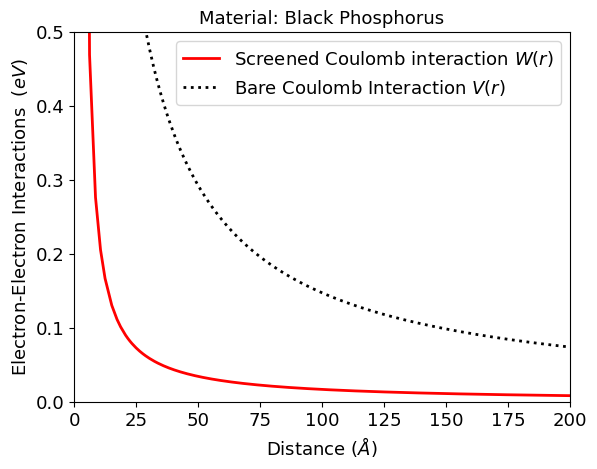

In [36]:
fig, ax = plt.subplots()


#PlotVintrold(irvec_w_e_F_32_12,Wint_rF,orbitales,lat,1,0,"red",r"$W_{RPA}$","o")
#PlotVintrold(irvec_v_L,Wread_T,orbitales,lat,1,0,"blue","merge",".")
#PlotVintrold(irvec_v_S,Wread_S,orbitales,lat,1,0,"green","short","-")
PlotVintrold(irvec_v_S,Wread_S,orbitales,lat,0,0,"red","Screened Coulomb interaction $W(r)$","-")
PlotVintrold(irvec_v_trial,V_bare,orbitales,lat,0,0,"black","Bare Coulomb Interaction $V(r)$",":")

plt.title("Material: Black Phosphorus",fontsize=13)
plt.ylim(-0.01*0,0.5)
plt.xlim(0,200)
plt.savefig("Screening_Coulomb_interaction.png",bbox_inches='tight')
plt.savefig("Screening_Coulomb_interaction.pdf",bbox_inches='tight')
plt.savefig("Screening_Coulomb_interaction.svg",bbox_inches='tight')